In [3]:
import numpy as np
from matplotlib import pylab as plt
%autosave 0
%matplotlib inline

Autosave disabled


# Sentimental Analysis 

### What is Sentimental Analysis?
Sentimental Analysis (aka "Opinion Mining") is the technique of analyzing the natural language used in subjective text-data to perceive and identify emotions. To classify a person's sentiment toward a particular subject brought up via survey responses, reviews, social media posts, email, or any other kind of textual sample, we typically generate a vocabulary based off of any relevant words used in said sample.  We can then utilize that vocabulary to make classifications regarding how positive or negative a particular text sample is.

| Customer Feedback       | Sentiment | 
| ---                     | ---       |
|“An amazing product for a great price “ | Positive |
|“This product is not worth the price “| Negative |





### Where is Sentimental Analysis utilized?
In our modern environment, companies have an enormous amount of data which consists of consumer feedback, social media tags, and many more. It is not feasible for a human to manually review that data and that’s where sentiment analysis and machine learning come into play. By running product reviews through sentiment analysis and machine learning algorithms, companies can gain a general understanding of consumer sentiment and make important design decisions about a current or future product. Sentimental Analysis can also be utilized in making investment decisions on the stock market by analyzing news sources and social media to gain an understanding of how other people feel about a particular security.

### Our approach is Machine learning-based Sentimental Analysis

In our case, we gathered thousands of Amazon product reviews and fed them into a model (Bag of Words) which generates a vocabulary containing words that appear across the entire given dataset.  Once the vocabulary is generated, each feature(review) is converted into a numerical representation of how frequently their words appear in the vocabulary.  These newly converted features were then split into train/test sets to be fed into our classifiers.  Each review came with a score in the range of 0.0-5.0 and we used these scores to define our labels with a score of 3.5 or more being labeled positive (1) and anything less than 3.5 as negative (0).  

The goal of our project was to compare the performance of a Feed Forward Neural Network to a couple of baseline classifiers: Random Forest and Decision Trees.


In [4]:
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from IPython.display import Image

In [5]:
import pandas as pd
import gzip
import json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [6]:
# feature selection
def select_features(df, max_features):
    X = df['reviewText']
    y = df['overall']

    features = np.array(X.tolist()[:max_features])
    scores = np.array(y.tolist()[:max_features])
    
    final_labels = []
    
    # generate labels
    for i in range(len(features)):
        if scores[i] >= 3.5:
            final_labels.append(1)
        else:
            final_labels.append(0)
    final_labels = np.array(final_labels)
    return (features, final_labels)


In [30]:
from sklearn.feature_extraction.text import CountVectorizer # for vectorization
from sklearn.feature_extraction.text import TfidfTransformer
import nltk # for stemming
# from nltk.stem.snowball import SnowballStemmer 
# nltk.download()

# stemmer = SnowballStemmer("english", ignore_stopwords=True)
# class StemmedCountVectorizer(CountVectorizer):
#     def build_analyzer(self):
#         analyzer = super(StemmedCountVectorizer, self).build_analyzer()
#         return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
# print(stemmed_count_vect)

def vectorize_reviews(features, max_features):
    vectorizer = CountVectorizer(stop_words='english')
    foo = vectorizer.fit_transform(features)
    tfidf = TfidfTransformer()
    X_train_tfidf = tfidf.fit_transform(foo)
    X_train_tfidf.shape


    return X_train_tfidf

In [17]:
#generate bag of words from selected features
def generate_bow(features, max_features, model):
    input_data = features
    input_data.shape = (max_features, 1)
    features_bow = model.predict(input_data)
    return features_bow

# Random Forest and Decision Tree

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [29]:
def run_random_forest(features, labels):
    classifier = RandomForestClassifier(n_estimators=10)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.40, random_state=17)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict_proba(X_test)
    #calculate f1 scores
    y_pred=y_pred[:,0]>=0.3
    y_pred_int = y_pred.astype(np.int)
    score = f1_score(y_test, y_pred_int)

    return score

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics._plot import confusion_matrix as cm

def run_decision_tree(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.33, random_state=42)


    pos_count = 0
    neg_count = 0

    for index, feat in enumerate(X_test):
        if y_train[index] == 1:
            pos_count += 1
        else:
            neg_count += 1


    print("number of positive training reviews", pos_count)
    print("number of negative training reviews", neg_count)
    

    nc = DecisionTreeClassifier(random_state = 2)
    nc.fit(X_train,y_train)

    y_p = nc.predict(X_test)

    matrix = confusion_matrix(y_test, y_p)
    print(matrix)
    return np.mean(y_p)


# Feed Foward Neural Network 

Feedforward neural network is an artificial neural network where the node doe not form connections and it is not a cycle. It is a classification algorithm, where neuron-like units or inputs is categorized in the form of layers. Each unit is connected with the previous. The data enters at the input and flows through the network until it reaches the outputs. When it acts as a classifier to compute the accuracy, no feedback is passed among the nodes of these Layers. Below is an image 

Image(filename = "FF.png", width = 800 , height = 200)

###   Reference 
"Feedforward neural networks 1. What is feedforward neural network ?",26th April,2004.https://www.fon.hum.uva.nl/praat/manual/Feedforward_neural_networks_1__What_is_a_feedforward_ne.html. 7th December 2020.


# Feed Foward Neural Network Implementation

In [21]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Convolution1D, GlobalMaxPooling1D

In [22]:
def build_nn_model():
    model = Sequential()
    #he taught us in class about relu it is more commonly used
    #sigmoid is used for the output layer
    #dense is basically adding layers to yout model for better input and output
    model.add(Dense(12, activation = 'relu'))
    model.add(Dense(8, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    #binary_cross used for binary classificaiton problems
    # adam = for gradient descent 
    #metric because this is a classificaiton problem 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Explanation 
A standard straightforward Feedforward neural network can implemented by just adding dense layers to a model. First we start of making a sequential constructor. A sequential constructor is a heap of linear layers. We are going to be using these Dense layers for our input and output parameteres. We have three Dense layers the first two have 12 and 8 nodes with our 'ReLU' as our activation feature. 

In [23]:
def run_ffnn(features, labels, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.33, random_state=42)

    history = model.fit(X_train, y_train , validation_split = 0.33, epochs = 150 , batch_size = 10)
    loss, accuracy = model.evaluate(X_test, y_test)
    #the lower the loss the closer our predicitons are to the  labels 
    print("Loss = ", loss)
    print("Accuracy = ", accuracy)
    print(history.history.keys()) # we don't need this but just to check for the keys getting stored
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model for Accuracies on Training and Testing set ')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Testing'], loc = 'upper left')
    plt.show()
   
    #history object records training metrics for each epochs basically stores the variables 
    #validation split is our test size 

In [34]:
df = getDF('Video_Games_5.json.gz')
max_features = 20000
features, labels = select_features(df, max_features)

# generate a vocabulary (bag of words) for a given set of text features 
features_bow = vectorize_reviews(features, max_features)
print(type(features_bow))
# features_bow = generate_bow(features, max_features, bow_model)

<class 'scipy.sparse.csr.csr_matrix'>


In [33]:
random_forest_score = run_random_forest(features_bow, labels)
print(random_forest_score)

0.22619481940897482


In [144]:
decision_tree_score = run_decision_tree(features_bow, labels)
print(decision_tree_score)

number of positive training reviews 5501
number of negative training reviews 1099
[[ 364  752]
 [ 594 4890]]
0.8548484848484849


Train on 4488 samples, validate on 2212 samples
Epoch 1/150
4488/4488 [==============================] - 1s 207us/step - loss: 0.4585 - accuracy: 0.8409 - val_loss: 0.3583 - val_accuracy: 0.8531
Epoch 2/150
4488/4488 [==============================] - 1s 186us/step - loss: 0.2685 - accuracy: 0.8870 - val_loss: 0.3721 - val_accuracy: 0.8671
Epoch 3/150
4488/4488 [==============================] - 1s 188us/step - loss: 0.1751 - accuracy: 0.9334 - val_loss: 0.3756 - val_accuracy: 0.8603
Epoch 4/150
4488/4488 [==============================] - 1s 189us/step - loss: 0.1110 - accuracy: 0.9635 - val_loss: 0.4340 - val_accuracy: 0.8653
Epoch 5/150
4488/4488 [==============================] - 1s 182us/step - loss: 0.0685 - accuracy: 0.9804 - val_loss: 0.5299 - val_accuracy: 0.8662
Epoch 6/150
4488/4488 [==============================] - 1s 190us/step - loss: 0.0430 - accuracy: 0.9880 - val_loss: 0.5890 - val_accuracy: 0.8703
Epoch 7/150
4488/4488 [==============================] - 1s 195us/step

Epoch 56/150
4488/4488 [==============================] - 1s 199us/step - loss: 0.0055 - accuracy: 0.9978 - val_loss: 1.8511 - val_accuracy: 0.8535
Epoch 57/150
4488/4488 [==============================] - 1s 193us/step - loss: 0.0058 - accuracy: 0.9975 - val_loss: 1.7612 - val_accuracy: 0.8486
Epoch 58/150
4488/4488 [==============================] - 1s 194us/step - loss: 0.0057 - accuracy: 0.9973 - val_loss: 1.8696 - val_accuracy: 0.8540
Epoch 59/150
4488/4488 [==============================] - 1s 194us/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 1.8347 - val_accuracy: 0.8504
Epoch 60/150
4488/4488 [==============================] - 1s 194us/step - loss: 0.0053 - accuracy: 0.9980 - val_loss: 1.8367 - val_accuracy: 0.8490
Epoch 61/150
4488/4488 [==============================] - 1s 194us/step - loss: 0.0057 - accuracy: 0.9975 - val_loss: 1.9310 - val_accuracy: 0.8517
Epoch 62/150
4488/4488 [==============================] - 1s 201us/step - loss: 0.0055 - accuracy: 0.9978 - val_

Epoch 111/150
4488/4488 [==============================] - 1s 203us/step - loss: 0.0051 - accuracy: 0.9982 - val_loss: 2.2171 - val_accuracy: 0.8463
Epoch 112/150
4488/4488 [==============================] - 1s 202us/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 2.1679 - val_accuracy: 0.8445
Epoch 113/150
4488/4488 [==============================] - 1s 195us/step - loss: 0.0052 - accuracy: 0.9975 - val_loss: 2.1734 - val_accuracy: 0.8445
Epoch 114/150
4488/4488 [==============================] - 1s 199us/step - loss: 0.0052 - accuracy: 0.9975 - val_loss: 2.3365 - val_accuracy: 0.8499
Epoch 115/150
4488/4488 [==============================] - 1s 198us/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 2.2181 - val_accuracy: 0.8449
Epoch 116/150
4488/4488 [==============================] - 1s 197us/step - loss: 0.0051 - accuracy: 0.9980 - val_loss: 2.3255 - val_accuracy: 0.8467
Epoch 117/150
4488/4488 [==============================] - 1s 197us/step - loss: 0.0051 - accuracy: 0.9980

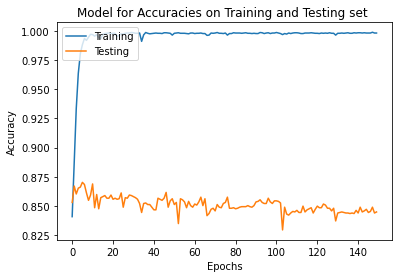

In [52]:
nn_model = build_nn_model()
run_ffnn(features_bow, labels, nn_model)




In [ ]:
df = getDF('Movies_and_TV_5.json.gz')
max_features = 10000
features, labels = select_features(df, max_features)

# generate a vocabulary (bag of words) for a given set of text features 
bow_model = create_bow_model(features, max_features)
features_bow = generate_bow(features, max_features, bow_model)


In [22]:
random_forest_score = run_random_forest(features_bow, labels)
print(random_forest_score)

0.9031182257795564


Train on 4488 samples, validate on 2212 samples
Epoch 1/150
4488/4488 [==============================] - 1s 204us/step - loss: 0.4182 - accuracy: 0.8418 - val_loss: 0.3534 - val_accuracy: 0.8413
Epoch 2/150
4488/4488 [==============================] - 1s 184us/step - loss: 0.2629 - accuracy: 0.8688 - val_loss: 0.3466 - val_accuracy: 0.8644
Epoch 3/150
4488/4488 [==============================] - 1s 182us/step - loss: 0.1699 - accuracy: 0.9403 - val_loss: 0.3999 - val_accuracy: 0.8603
Epoch 4/150
4488/4488 [==============================] - 1s 186us/step - loss: 0.0922 - accuracy: 0.9717 - val_loss: 0.7751 - val_accuracy: 0.8612
Epoch 5/150
4488/4488 [==============================] - 1s 186us/step - loss: 0.0593 - accuracy: 0.9828 - val_loss: 0.5901 - val_accuracy: 0.8617
Epoch 6/150
4488/4488 [==============================] - 1s 202us/step - loss: 0.0335 - accuracy: 0.9918 - val_loss: 0.6285 - val_accuracy: 0.8553
Epoch 7/150
4488/4488 [==============================] - 1s 185us/step

Epoch 110/150
4488/4488 [==============================] - 1s 201us/step - loss: 0.0051 - accuracy: 0.9980 - val_loss: 2.4670 - val_accuracy: 0.8377
Epoch 111/150
4488/4488 [==============================] - 1s 196us/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 2.5222 - val_accuracy: 0.8373
Epoch 112/150
4488/4488 [==============================] - 1s 201us/step - loss: 0.0051 - accuracy: 0.9978 - val_loss: 2.4772 - val_accuracy: 0.8354
Epoch 113/150
4488/4488 [==============================] - 1s 197us/step - loss: 0.0052 - accuracy: 0.9978 - val_loss: 2.5115 - val_accuracy: 0.8377
Epoch 114/150
4488/4488 [==============================] - 1s 193us/step - loss: 0.0051 - accuracy: 0.9982 - val_loss: 2.5680 - val_accuracy: 0.8377
Epoch 115/150
4488/4488 [==============================] - 1s 201us/step - loss: 0.0049 - accuracy: 0.9980 - val_loss: 2.4654 - val_accuracy: 0.8296
Epoch 116/150
4488/4488 [==============================] - 1s 203us/step - loss: 0.0049 - accuracy: 0.9980

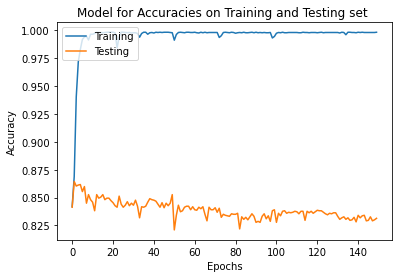

In [53]:
nn_model = build_nn_model()
run_ffnn(features_bow, labels, nn_model)